## FINAL PROJECT - 02456 DEEP LEARNING
### SEGMENTATION OF CAR PARTS 
### COLLABORATION WITH DELOITTE CONSULTING

#### Authors
>*Sanem Leblebici - s222448*

>*Michal Lehwark - s222999*

>*Ari Menachem - s163956*

>*Elli Georgiou - s223408*


In [1]:
from tqdm import tqdm
import torch
import numpy as np
import torch.nn as nn
from modules.model import UNET
from modules.settings import COLAB_PATH, NUM_EPOCHS,BATCH_SIZE,SPLIT_RATIO, LEARNING_RATE, device
from modules.utils import get_data_loaders
from modules.resizeImages import resize_with_pad
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from PIL import Image
import os
import cv2
from typing import Tuple
from torchsummary import summary


### Load the trained model

In [6]:
mdl = UNET(in_channels=3, out_channels=10)

## Can uncomment the next line if your device has gpu
# mdl.load_state_dict(torch.load('./models/unet_nov18.pth'))

mdl.load_state_dict(torch.load('./models/nov19/unet_nov19_1.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

### TEST LOOP

0071.jpg
Size of the test image  1  :  (256, 256, 3)
Test prediction completed for image  1
0065.jpg
Size of the test image  2  :  (256, 256, 3)
Test prediction completed for image  2
0059.jpg
Size of the test image  3  :  (256, 256, 3)
Test prediction completed for image  3
0105.jpg
Size of the test image  4  :  (256, 256, 3)
Test prediction completed for image  4
0111.jpg
Size of the test image  5  :  (256, 256, 3)
Test prediction completed for image  5
0139.jpg
Size of the test image  6  :  (256, 256, 3)
Plotting test image  6


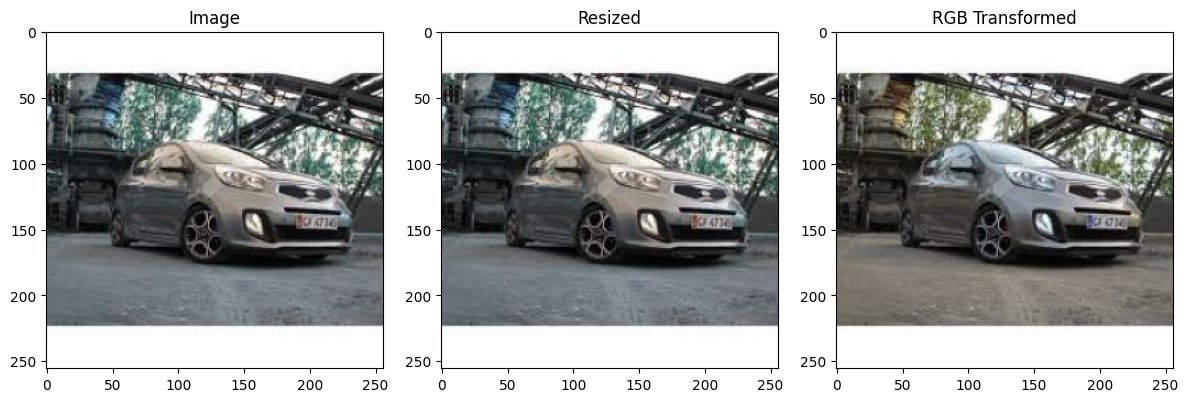

Test prediction completed for image  6
0138.jpg
Size of the test image  7  :  (256, 256, 3)
Test prediction completed for image  7
0110.jpg
Size of the test image  8  :  (256, 256, 3)
Test prediction completed for image  8
0104.jpg
Size of the test image  9  :  (256, 256, 3)
Test prediction completed for image  9
0058.jpg
Size of the test image  10  :  (256, 256, 3)
Test prediction completed for image  10
0064.jpg
Size of the test image  11  :  (256, 256, 3)


In [45]:

test_folder_path = './data/carseg_data/images/photo/no_segmentation'  # Replace with the actual path
masks_path = './data/carseg_data/arrays'

# Create a list to store the model outputs
model_outputs = []
model_outputs_images = []
model_outputs_gt = []

# Set the model to evaluation mode
mdl.eval()

# Define the transformation to be applied to the input images
transform = transforms.Compose([transforms.ToTensor()])
how_many_images_to_test = 10
index = 0

# Iterate through the images in the test folder
for filename in os.listdir(test_folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        print(filename)
        # Load the image
        image_path = os.path.join(test_folder_path, filename)
        
        name, ext = filename.split('.')
        mask_string = "photo_" + name + ".npy"
        mask_path = os.path.join(masks_path, mask_string)
        mask = np.load(mask_path)
        mask = mask//10
        
        img = cv2.imread(image_path)
        print("Size of the test image ", index+1, " : ", img.shape)
        resized = resize_with_pad(img, (256, 256))
        img_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        
        # Apply the specified transformations
        input_image = transform(img_rgb).unsqueeze(0)  # Add batch dimension
        
        # show an example image at an index
        if index == 5:
          print("Plotting test image ", index+1)
          fig, axes = plt.subplots(1, 3, figsize=(12, 4))
          axes[0].imshow(img)
          axes[0].set_title('Image')
          axes[1].imshow(resized)
          axes[1].set_title('Resized')
          axes[2].imshow(img_rgb)
          axes[2].set_title('RGB Transformed')
          plt.tight_layout()
          plt.show()

        # Make the prediction
        with torch.no_grad():
            output = mdl(input_image)

        # Store the output in the list
        model_outputs.append(output)
        model_outputs_images.append(img_rgb)
        model_outputs_gt.append(mask)

        #detect for first 10 images
        if index == how_many_images_to_test:
          break
        index = index + 1
        print("Test prediction completed for image ", index)

# The `model_outputs` list now contains the model's output for each test image

In [46]:
# Should be size 1, 10, 256, 256 for 1 image with 10 classes with 256x256 size
print(model_outputs[0].shape)
output = []
for out in model_outputs:
  print(out.argmax(dim=1).unique())
  output.append(out.argmax(dim=1))

torch.Size([1, 10, 256, 256])
tensor([0, 9])
tensor([0, 9])
tensor([0, 9])
tensor([0, 9])
tensor([0, 9])
tensor([0, 9])
tensor([0, 9])
tensor([0, 9])
tensor([0, 9])
tensor([0, 9])
tensor([0, 9])


### COLORFUL SEGMENTATION PLOT AND LOSS PLOTS

In [47]:
def plot_loss_from_txt(file_path):
    # Read data from the text file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract data from each line
    indices, train_losses, val_losses = [], [], []
    for line in lines[1:]:  # Assuming the first line contains column headers
        index, train_loss, val_loss = map(float, line.strip().split())
        indices.append(index)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(indices, train_losses, label='Train Loss', marker='o', linestyle='-')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(indices, val_losses, label='Validation Loss', marker='o', linestyle='-')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

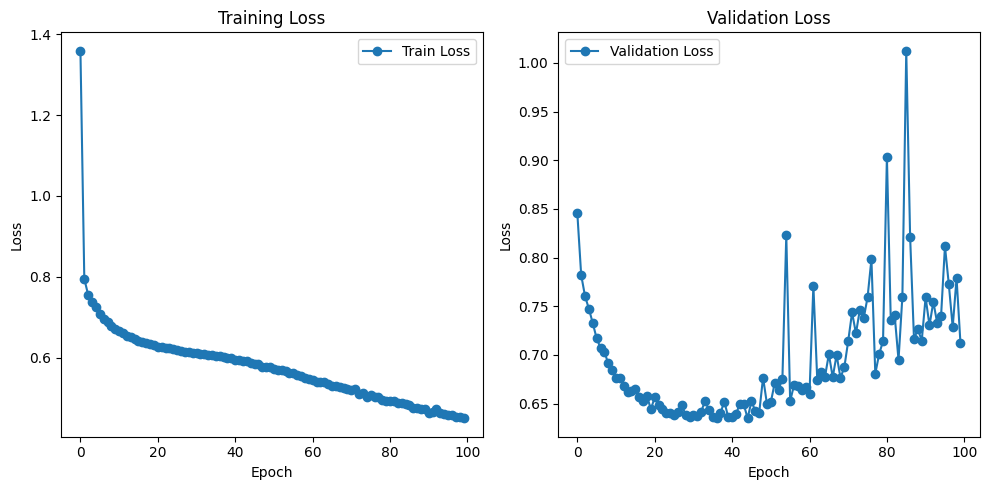

In [30]:
plot_loss_from_txt('./models/nov19/loss_data_nov19_1.txt')

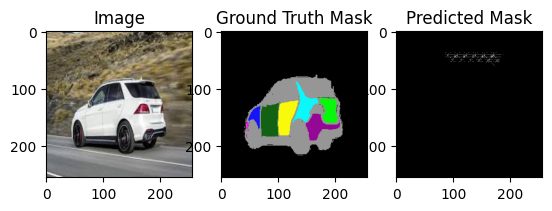

In [49]:
# Define color mapping for each class
color_mapping = {
        0: (0,0,0),
        1: (250, 149, 10),
        2: (19, 98, 19),
        3: (249, 249, 10),
        4: (10, 248, 250),
        5: (149, 7, 149),
        6: (5, 249, 9),
        7: (20, 19, 249),
        8: (249, 9, 250),
        9: (150, 150, 150),
    }

def colorize_segmentation_mask(segmentation_tensor_or_mask, mask = False):
    # Convert the PyTorch tensor to a NumPy array
    if mask == False:
        segmentation_array = segmentation_tensor.squeeze(0).cpu().numpy()
    else:
        segmentation_array = segmentation_tensor_or_mask[:, :, 3]

    # Create a mapping from actual class values to color values
    class_to_color = {class_value: color_mapping[class_value] for class_value in np.unique(segmentation_array)}

    # Create an RGB image with the colored segmentation mask
    colored_mask = np.zeros((256, 256, 3), dtype=np.uint8)
    for class_value, color in class_to_color.items():
        colored_mask[segmentation_array == class_value] = color

    return colored_mask

image_index_to_display = 1
# Example usage:
# Assuming `model_outputs` is a list containing tensors with shapes [1, 10, 256, 256]
segmentation_tensor = output[image_index_to_display]  # Assuming we're using the output of the first image

plt.subplot(1, 3, 1)
plt.imshow(model_outputs_images[image_index_to_display])
plt.title('Image')

plt.subplot(1, 3, 2)
# img_rgb = cv2.cvtColor(model_outputs_images[image_index_to_display], cv2.COLOR_BGR2RGB)
plt.imshow(colorize_segmentation_mask(model_outputs_gt[image_index_to_display], True))
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
colored_mask = colorize_segmentation_mask(segmentation_tensor)
plt.imshow(colored_mask)
plt.title('Predicted Mask')

plt.show()

In [19]:
img_path = 'data/carseg_data/arrays/black_5_doors_0001.npy'
img_array = np.load(img_path)
print('unique values in class channel of black_5_doors_0001.npy:', np.unique(img_array[:, :, 3]), sep='\n')
print('sample from class channel in area [56:61, 105:110] of black_5_doors_0001.npy:', img_array[56:61, 106:110, 3], sep='\n')


unique values in class channel of black_5_doors_0001.npy:
[ 0 10 20 30 40 50 60 70 80 90]
sample from class channel in area [56:61, 105:110] of black_5_doors_0001.npy:
[[90 90 90 90]
 [40 40 40 90]
 [40 40 40 90]
 [40 40 90 30]
 [40 40 30 30]]
